# **Week 14: Neural Ordinary Differential Equations**

[Neural ODE original paper](https://arxiv.org/abs/1806.07366)



In today's class, we are going to cover <br>

## **1.  Solvers**
1-1. Euler <br> 
1-2. Runge-Kutta4 (RK4)<br>

## **2.  Neural ODEs**
2-1. implement Neural ODEs

## **3.  Experiments**
3-1. check our Neural ODE<br>
3-1. spiral dataset<br>

## **4.  Comparison**
4-1. comparison with adaptive solvers  
4-2. comparison with adjoint backpropagation method


### **0. Import Packages**

In [ ]:
!pip install torchdiffeq

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

import numpy as np
from tqdm.notebook import tqdm
import time

import matplotlib.pyplot as plt
%matplotlib inline

### **1. Solvers**
A solver applies a numerical method to solve the set of ordinary differential equations that represent the model. 
There are two kinds of solvers: **fixed step size solvers**, **adaptive step size solvers.**

**Fixed-step size solvers** solve the model using the same step size from the beginning to the end of the simulation. Generally, small step size increases the accuracy of the results and the time required to simulate the system.


**Adaptive-step size solvers** vary the step size during the simulation. These solvers reduce the step size to increase accuracy at certain events during the simulation of the model, such as rapid state changes, zero-crossing events, etc. Also, they increase the step size to avoid taking unnecessary steps when the states of a model change slowly.

#### **Euler solver**
Euler's method is one of the oldest and simplest algorithms.  
The core idea is approximating the solution function step by step using tangents lines.

Here, we are going to make a new function that calculates euler_step.  
Please refer to the below equation.  

<br>

**Euler's Method**

when  $\frac{dy}{dt} = f(t, y)$ and   $y(t_0) = y_0$, then  $y_t = y_0 + f(t_0, y_0)(t-t_0)$



In [ ]:
def euler(func, t, dt, y):
  return dt * func(t, y)

**Runge-Kutta method**

Runge-Kutta(also known as rk) is one of popular methods used to solve the equation

Here, we are going to make a new function that calculates runge-kutta4 method
please refer to the below equation


![picture](https://drive.google.com/uc?id=1N4Yl8ZtaOjKU2esHtrdtGP-296ngFGVq)
![picture](https://drive.google.com/uc?id=191ElkdaEvDVmRvQaF2eqr5XmUgEZwpbs)

In [ ]:
def rk4(func, t, dt, y):
  _one_sixth = 1/6
  half_dt = dt * 0.5

  k1 = func(t, y)
  k2 = func(t + half_dt, y + half_dt * k1)
  k3 = func(t + half_dt, y + half_dt * k2)
  k4 = func(t + dt, y + dt * k3)
  
  return (k1 + 2 * (k2 + k3) + k4) * dt * _one_sixth 

### **2. Neural ODEs**

In this practice, we are going to implement Neural ODEs

In [ ]:
# Neural ODE model
class NeuralODE(nn.Module):
  def __init__(self, func):
    super().__init__()
    self.func = func

  def forward(self, y0, t, solver):
    solution = torch.empty(len(t), *y0.shape, dtype=y0.dtype, device=y0.device)
    solution[0] = y0

    j = 1
    for t0, t1 in zip(t[:-1], t[1:]):
      dy = solver(self.func, t0, t1 - t0, y0)
      y1 = y0 + dy
      solution[j] = y1
      j += 1
      y0 = y1
    return solution

### **3. Experiments**
**3-1. Check our Neural ODEs**

we are going to check out NODEs result by giving dynamic of cos(t). The result will be sin(t) 

In [ ]:
y0 = torch.Tensor([[0]]).cuda()
t = torch.linspace(0., 6*np.pi, 1500).cuda()

class cos(nn.Module):
  def forward(self, t, y):
    return torch.cos(t)

In [ ]:
ode_test = NeuralODE(func=cos()).cuda()
test_result = ode_test(y0=y0, t=t, solver=euler)

# make sure you transpose
test_result = test_result.transpose(0, 1)

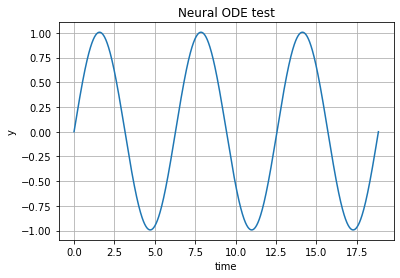

In [ ]:
# visualize result
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.set_title('Neural ODE test')
ax.set_xlabel('time')
ax.set_ylabel('y')
ax.plot(t.cpu().numpy(), test_result[0].detach().cpu().numpy())
plt.grid(True)
plt.show()

**3-2. sprial dataset**  
Here, we are going to test our Neural ODEs in toy sprial datset. 


In [ ]:
data_size = 2000

In [ ]:
# generate toy dataset
true_y0 = torch.tensor([[2., 0.]]).cuda()
t = torch.linspace(0., 25., data_size).cuda()
true_A = torch.tensor([[-0.1, 2.0], [-2.0, -0.1]]).cuda()


class Lambda(nn.Module):
  def forward(self, t, y):
    return torch.mm(y**3, true_A)

with torch.no_grad():
  node = NeuralODE(func=Lambda()).cuda()
  true_y = node(y0=true_y0, t=t, solver=euler)

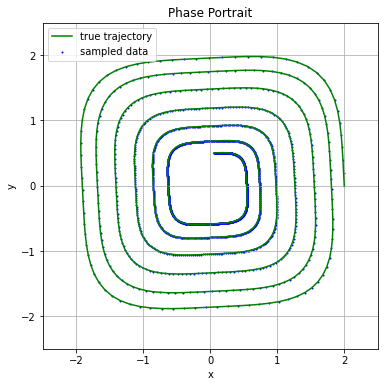

In [ ]:
def visualize(true_y, pred_y=None):
  fig = plt.figure(figsize=(6, 6), facecolor='white')
  ax = fig.add_subplot(111)
  ax.set_title('Phase Portrait')
  ax.set_xlabel('x')
  ax.set_ylabel('y')
  ax.plot(true_y.cpu().numpy()[:, 0, 0], true_y.cpu().numpy()[:, 0, 1], 'green', label='true trajectory')
  ax.scatter(true_y.cpu().numpy()[:, 0, 0], true_y.cpu().numpy()[:, 0, 1], color='blue', label='sampled data', s=1)
  if pred_y is not None:
    ax.plot(pred_y.cpu().numpy()[:, 0, 0], pred_y.cpu().numpy()[:, 0, 1], 'red', label='learned trajectory')
  ax.set_xlim(-2.5, 2.5)
  ax.set_ylim(-2.5, 2.5)
  plt.legend()
  plt.grid(True)
  plt.show()

visualize(true_y)

In [ ]:
batch_time = 10
batch_size = 16

def get_batch():
  s = torch.from_numpy(np.random.choice(np.arange(data_size - batch_time, dtype=np.int64), batch_size, replace=False))
  batch_y0 = true_y[s]  # (batch_size, 1, emb)
  batch_t = t[:batch_time]  # (T)
  batch_y = torch.stack([true_y[s + i] for i in range(batch_time)], dim=0)  # (time, batch_size, 1, emb)
  return batch_y0.cuda(), batch_t.cuda(), batch_y.cuda()

In [ ]:
# define dynamic function
class ODEFunc(nn.Module):
  def __init__(self):
    super().__init__()
    self.net = nn.Sequential(nn.Linear(2, 50),
                             nn.Tanh(),
                             nn.Linear(50, 2))
    for m in self.net.modules():
      if isinstance(m, nn.Linear):
        nn.init.normal_(m.weight, mean=0, std=0.1)
        nn.init.constant_(m.bias, val=0)

  def forward(self, t, y):
    output = self.net(y**3)
    return output

Iter 0000 | Total Loss 1.048884


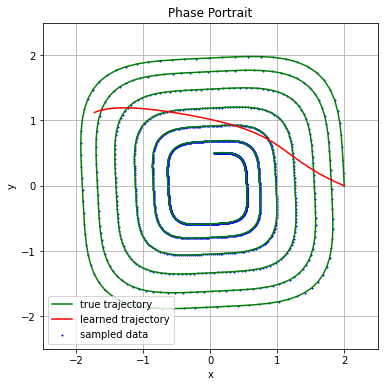

Iter 0050 | Total Loss 0.783337


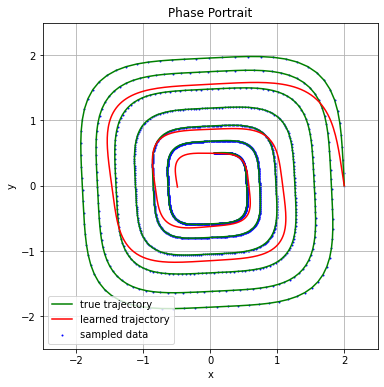

Iter 0100 | Total Loss 0.897098


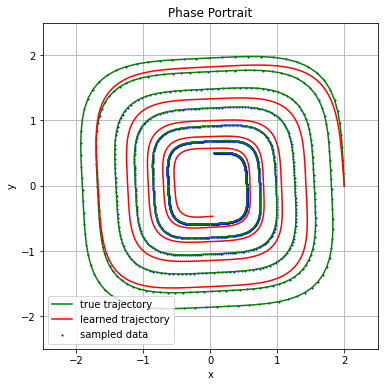

Iter 0150 | Total Loss 0.899753


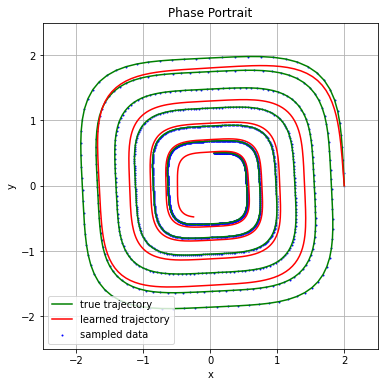

Iter 0200 | Total Loss 0.776522


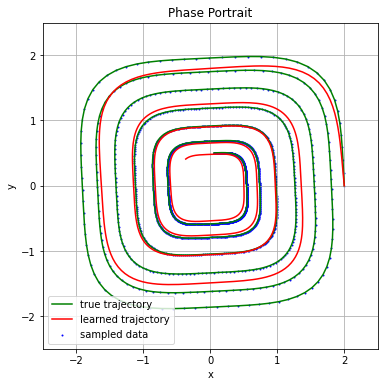

Iter 0250 | Total Loss 0.888727


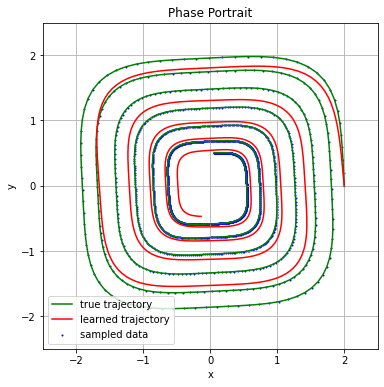

Iter 0300 | Total Loss 0.557032


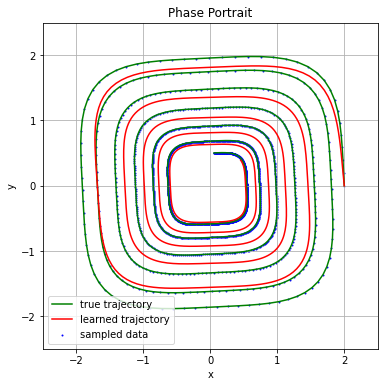

Iter 0350 | Total Loss 0.369367


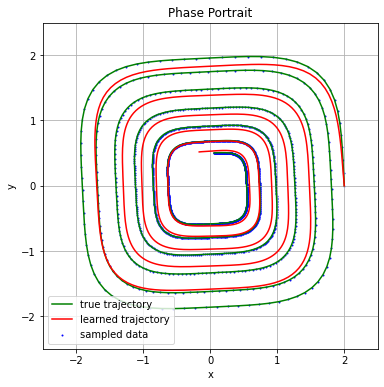

Iter 0400 | Total Loss 0.743200


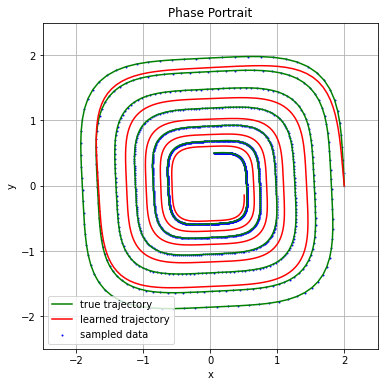


process time: 28.26686668395996 sec


In [ ]:
## Train
niters = 400

node = NeuralODE(func=ODEFunc()).cuda()
optimizer = optim.RMSprop(node.parameters(), lr=1e-3)

start_time = time.time()

for iter in tqdm(range(niters + 1)):
  optimizer.zero_grad()
  batch_y0, batch_t, batch_y = get_batch()
  pred_y = node(y0=batch_y0, t=batch_t, solver=rk4)
  loss = torch.mean(torch.abs(pred_y - batch_y))
  loss.backward()
  optimizer.step()

  if iter % 50 == 0:
    with torch.no_grad():
      pred_y = node(true_y0, t, solver=rk4)
      loss = torch.mean(torch.abs(pred_y - true_y))
      print('Iter {:04d} | Total Loss {:.6f}'.format(iter, loss.item()))
      visualize(true_y, pred_y)

end_time = time.time() - start_time
print('process time: {} sec'.format(end_time))

### **4. Experiments**
**4-1. comparison with adaptive solvers**

we going to implement adaptvie solver using `torchdiffeq` package.  

`torchdiffeq` library provides main interface odeint which contains general-purpose algorithms for solving initial value problems (IVP).  

To solve an IVP using the default solver:


```
from torchdiffeq import odeint
odeint(func, y0, t, rtol, atol, method)
```

**Arguments**  
*rtol*: optional float64 Tensor specifying an upper bound on relative error  
*atol*: optional float64 Tensor specifying an upper bound on absolute error


In [ ]:
from torchdiffeq import odeint

Iter 0000 | Total Loss 0.967178


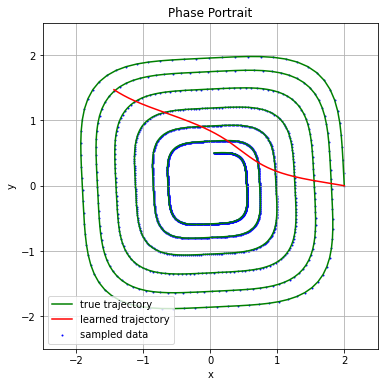

Iter 0050 | Total Loss 0.666198


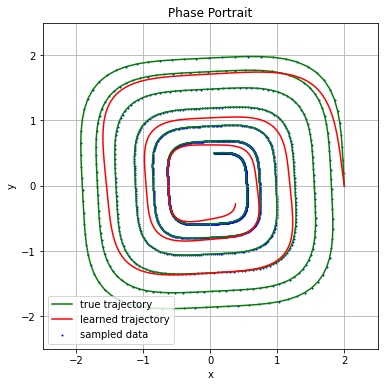

Iter 0100 | Total Loss 0.739874


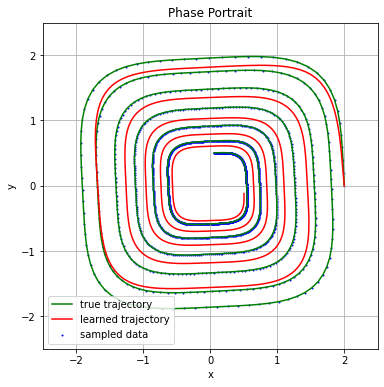

Iter 0150 | Total Loss 0.748837


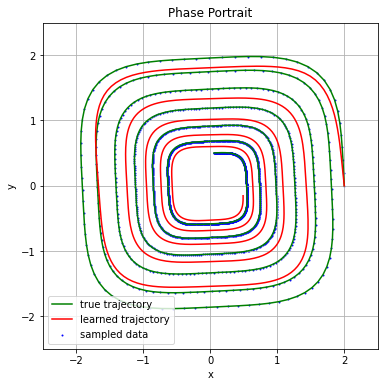

Iter 0200 | Total Loss 0.594309


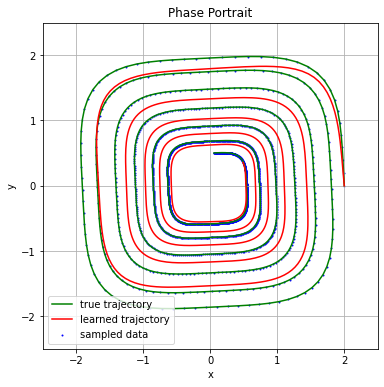

Iter 0250 | Total Loss 0.728726


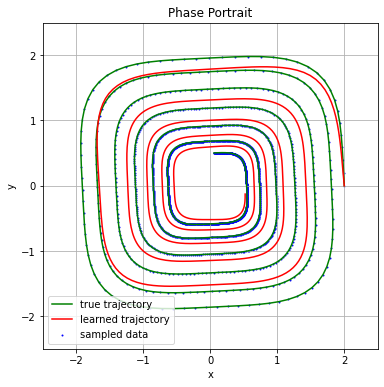

Iter 0300 | Total Loss 0.723695


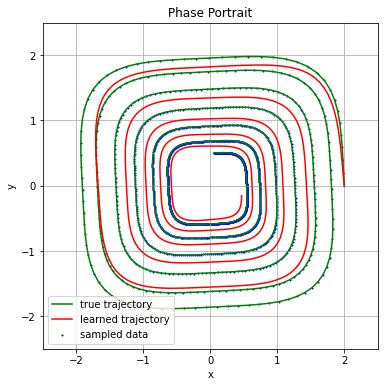

Iter 0350 | Total Loss 0.867360


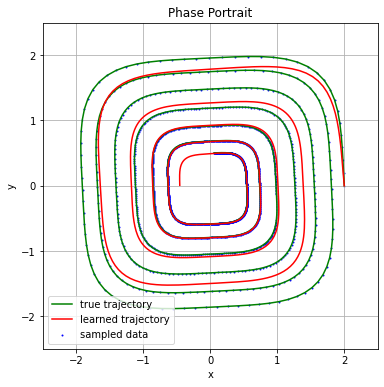

Iter 0400 | Total Loss 0.681332


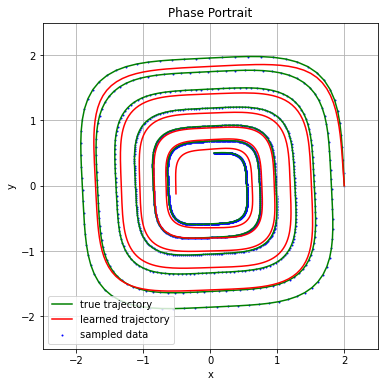


process time: 43.57051491737366 sec


In [ ]:
## Train
niters = 400

func = ODEFunc().cuda()
optimizer = optim.RMSprop(func.parameters(), lr=1e-3)

start_time = time.time()

for iter in tqdm(range(niters + 1)):
  optimizer.zero_grad()
  batch_y0, batch_t, batch_y = get_batch()
  pred_y = odeint(func = func, y0=batch_y0, t=batch_t, rtol=1e-7, atol=1e-9, method='dopri5')
  loss = torch.mean(torch.abs(pred_y - batch_y))
  loss.backward()
  optimizer.step()

  if iter % 50 == 0:
    with torch.no_grad():
      pred_y = odeint(func, true_y0, t, rtol=1e-7, atol=1e-9, method='dopri5')
      loss = torch.mean(torch.abs(pred_y - true_y))
      print('Iter {:04d} | Total Loss {:.6f}'.format(iter, loss.item()))
      visualize(true_y, pred_y)

end_time = time.time() - start_time
print('process time: {} sec'.format(end_time))

### **4. Experiments**
**4-2. comparison with adjoint backpropagation method**

we going to implement adjoint backpropgation using `torchdiffeq` package.  

Backpropagation through odeint goes through the internals of the solver. Note that this is not numerically stable for all solvers (but should probably be fine with the default dopri5 method). Instead, we encourage the use of the adjoint method explained in [1], which will allow solving with as many steps as necessary due to memory usage. 



```
from torchdiffeq import odeint_adjoint as odeint
odeint_adjoint(func, y0, t, rtol, atol, method)
```

Iter 0000 | Total Loss 0.913928


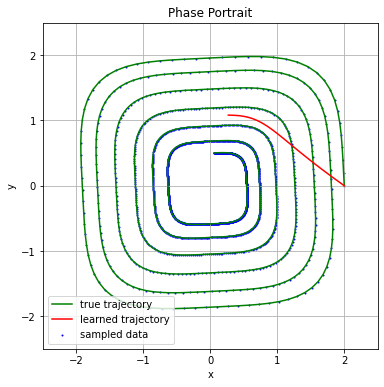

Iter 0050 | Total Loss 0.783712


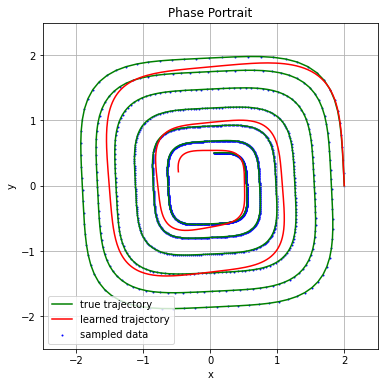

Iter 0100 | Total Loss 0.572322


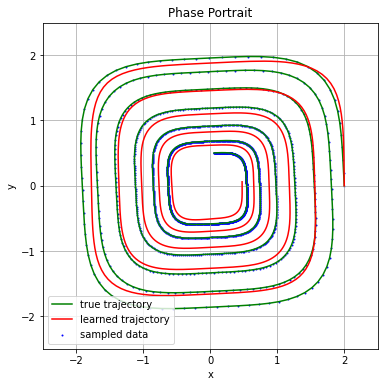

Iter 0150 | Total Loss 0.878030


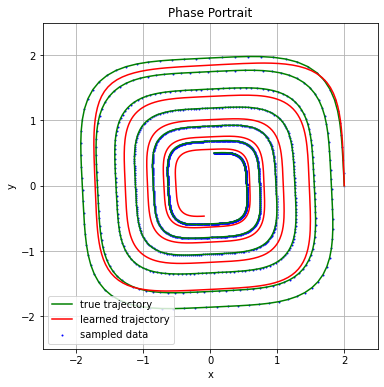

Iter 0200 | Total Loss 0.884970


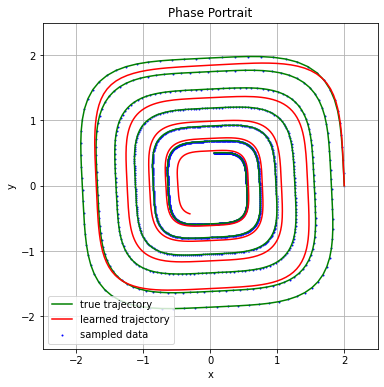

Iter 0250 | Total Loss 0.768459


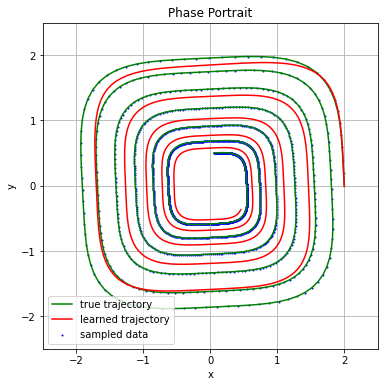

Iter 0300 | Total Loss 0.985418


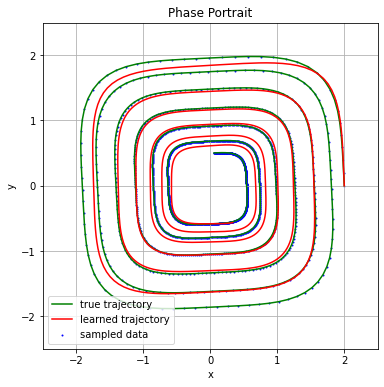

Iter 0350 | Total Loss 0.779876


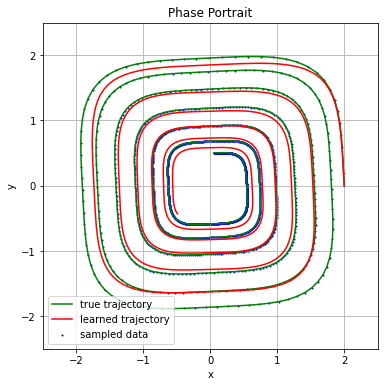

Iter 0400 | Total Loss 0.858406


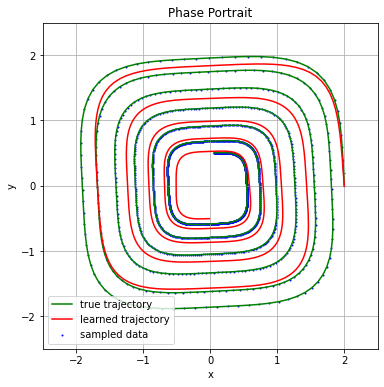


process time: 98.42891788482666 sec


In [ ]:
from torchdiffeq import odeint_adjoint

## Train
niters = 400

func = ODEFunc().cuda()
optimizer = optim.RMSprop(func.parameters(), lr=1e-3)

start_time = time.time()

for iter in tqdm(range(niters + 1)):
  optimizer.zero_grad()
  batch_y0, batch_t, batch_y = get_batch()
  pred_y = odeint_adjoint(func = func, y0=batch_y0, t=batch_t, rtol=1e-7, atol=1e-9, method='dopri5')
  loss = torch.mean(torch.abs(pred_y - batch_y))
  loss.backward()
  optimizer.step()

  if iter % 50 == 0:
    with torch.no_grad():
      pred_y = odeint_adjoint(func, true_y0, t, rtol=1e-7, atol=1e-9, method='dopri5')
      loss = torch.mean(torch.abs(pred_y - true_y))
      print('Iter {:04d} | Total Loss {:.6f}'.format(iter, loss.item()))
      visualize(true_y, pred_y)

end_time = time.time() - start_time
print('process time: {} sec'.format(end_time))

##**Reference**

#### Neural ODEs
https://towardsdatascience.com/neural-odes-breakdown-of-another-deep-learning-breakthrough-3e78c7213795

https://github.com/rtqichen/torchdiffeq

####Solvers
https://kr.mathworks.com/help/simulink/ug/choose-a-solver.html